In [1]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def run():
    # simulation and data collection
    simulationSteps = 500
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 15.0,                                     # leverage ratio upper bound for all banks
                    capitalReserve = 0.0,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 30,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04/252,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.04/252,                                # return rate on portfolio
                    liquidityShockNum = 2,                                    # number of liquidity shocks per step      
                    shockSize = 0.1,                                          # size of the shock
                    shockDuration =  [simulationSteps // 10 * 6, simulationSteps // 10 * 7]) # duration of the shock
                    
    model.datacollector.collect(model)
    for i in tqdm(range(simulationSteps)):
        model.simulate()

    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data, model

model_data_collection = []
agent_data_collection = []
model_collection = []
for _ in range(10):
    m, a, model = run()
    model_data_collection.append(m)
    agent_data_collection.append(a)
    model_collection.append(model)

100%|██████████| 500/500 [01:12<00:00,  6.90it/s]


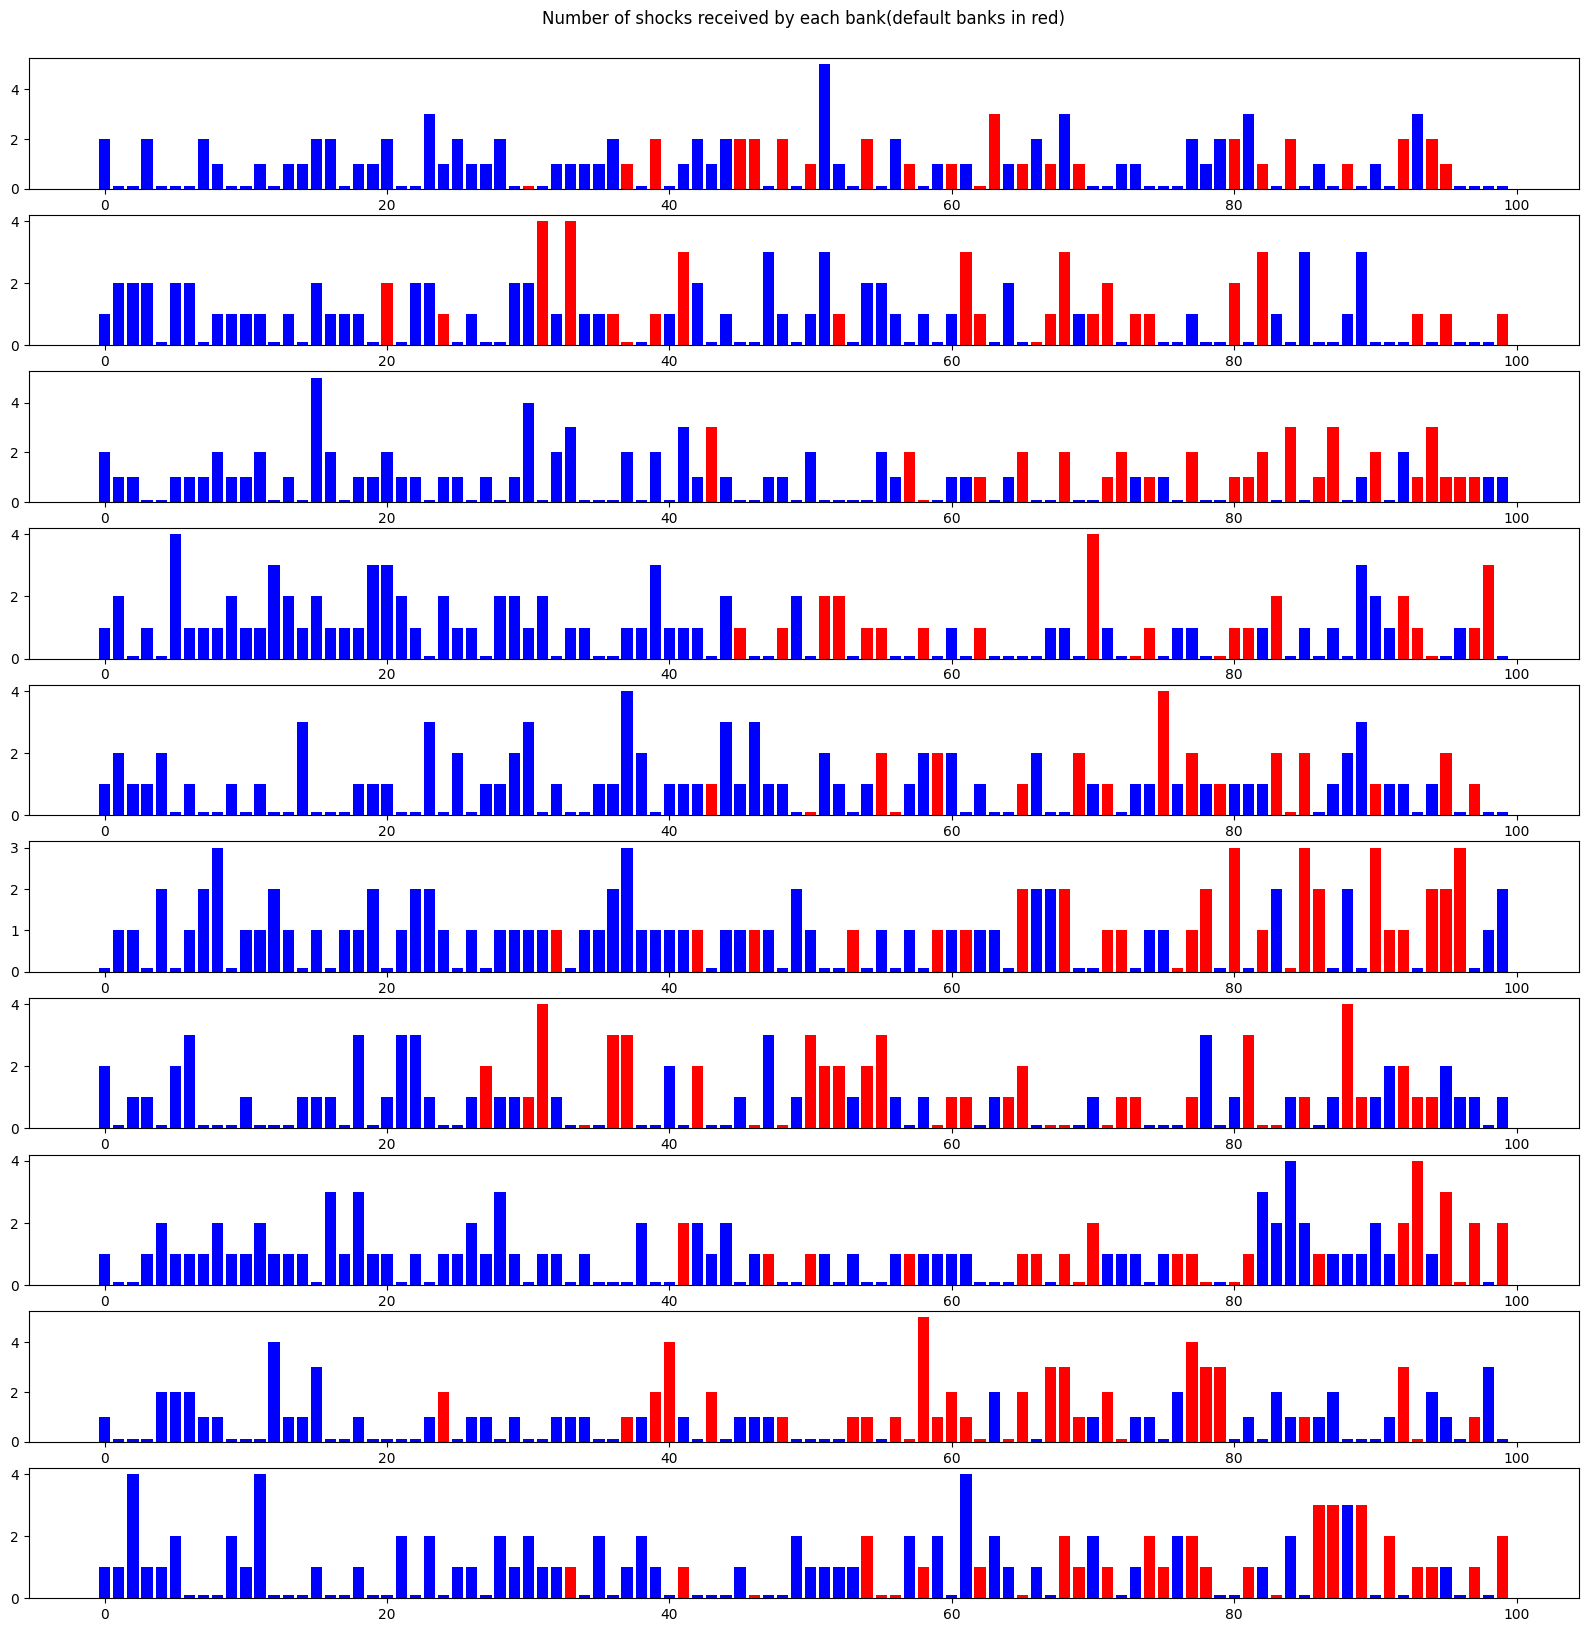

In [3]:
# shock analysis
simulationSteps=500
fig, axes = plt.subplots(nrows=10, ncols=1)
axes = axes.ravel()

plt.title("Number of shocks received by each bank(default banks in red)", y = 12)
for agent_data, model,j in zip(agent_data_collection, model_collection, range(10)):
    agents_df = agent_data.xs(simulationSteps, level="Step")
    defaults = agents_df[agents_df.Default ==True].index
    red_bars = defaults
    keyVals = [] 
    for k, v in model.shockedBanks.items():
        keyVals.append([k,v])
    
    for i in range(100):
        if i not in model.shockedBanks:
            keyVals.append([i,0.1])
    
    keyVals = np.array(keyVals)
    bar_colors = ['red' if i in red_bars else 'blue' for i in keyVals[:,0]]
    axes[j].bar(keyVals[:,0], keyVals[:,1],color=bar_colors)
plt.show()

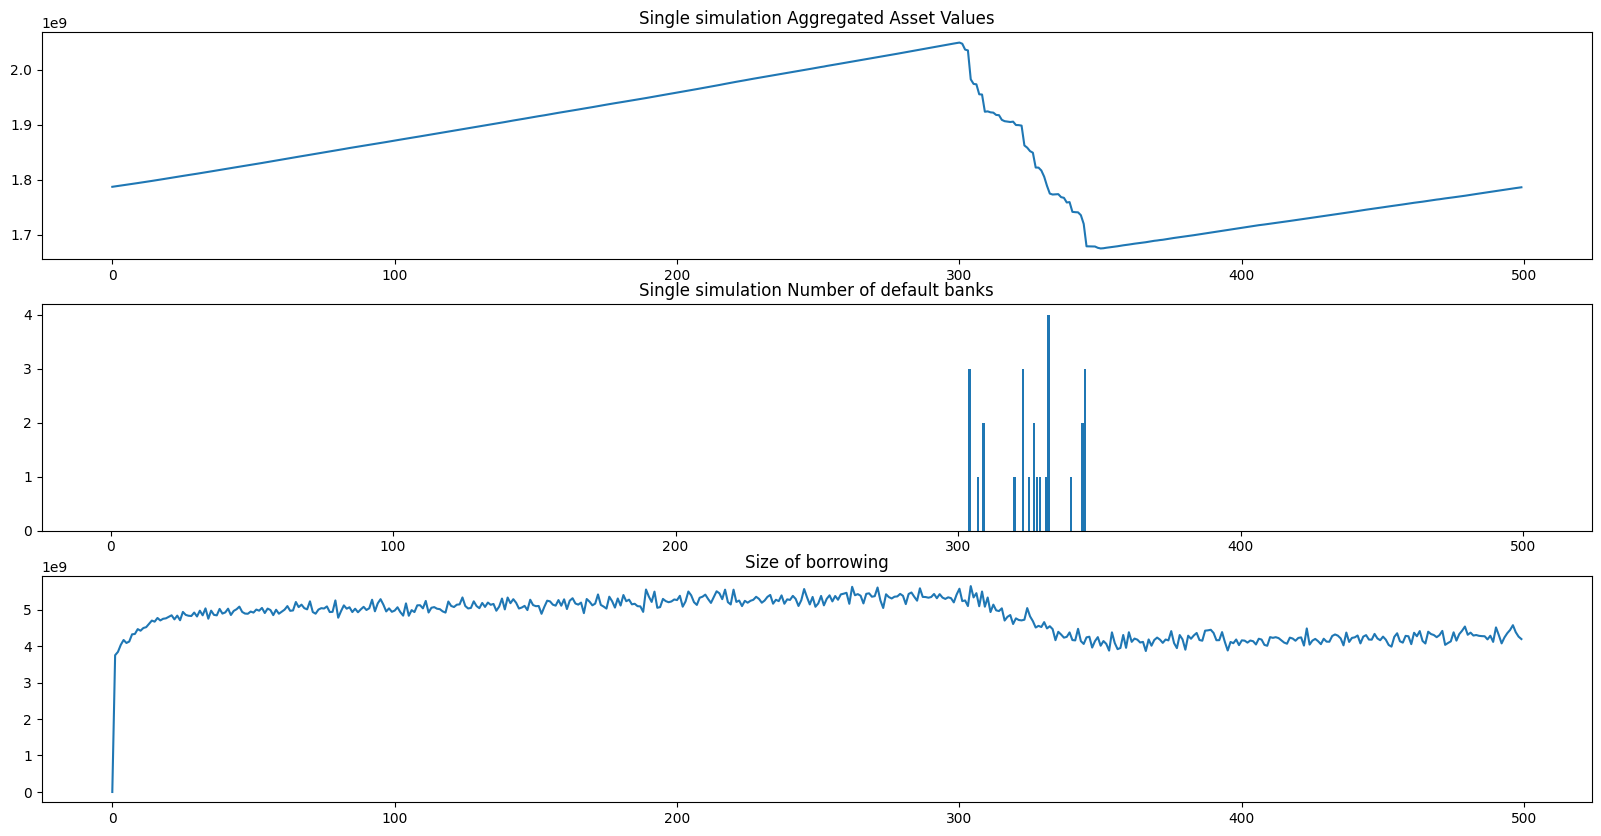

In [11]:
numberOfDefault = [agent_data.xs(i, level="Step")["Default"].sum() for i in range(simulationSteps)]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(20, 10)
ax1.plot(range(simulationSteps), [agent_data.xs(i, level="Step")["PortfolioValue"].sum() for i in range(simulationSteps)])
ax1.set_title("Single simulation Aggregated Asset Values")
ax2.bar(range(1, simulationSteps), np.diff(numberOfDefault))
ax2.set_title("Single simulation Number of default banks")
ax3.plot(np.array([[model_data_collection[j]["Liability Matrix"][i].sum() for i in range(simulationSteps)] for j in range(10)]).mean(axis=0))
ax3.set_title("Size of borrowing")
plt.show()

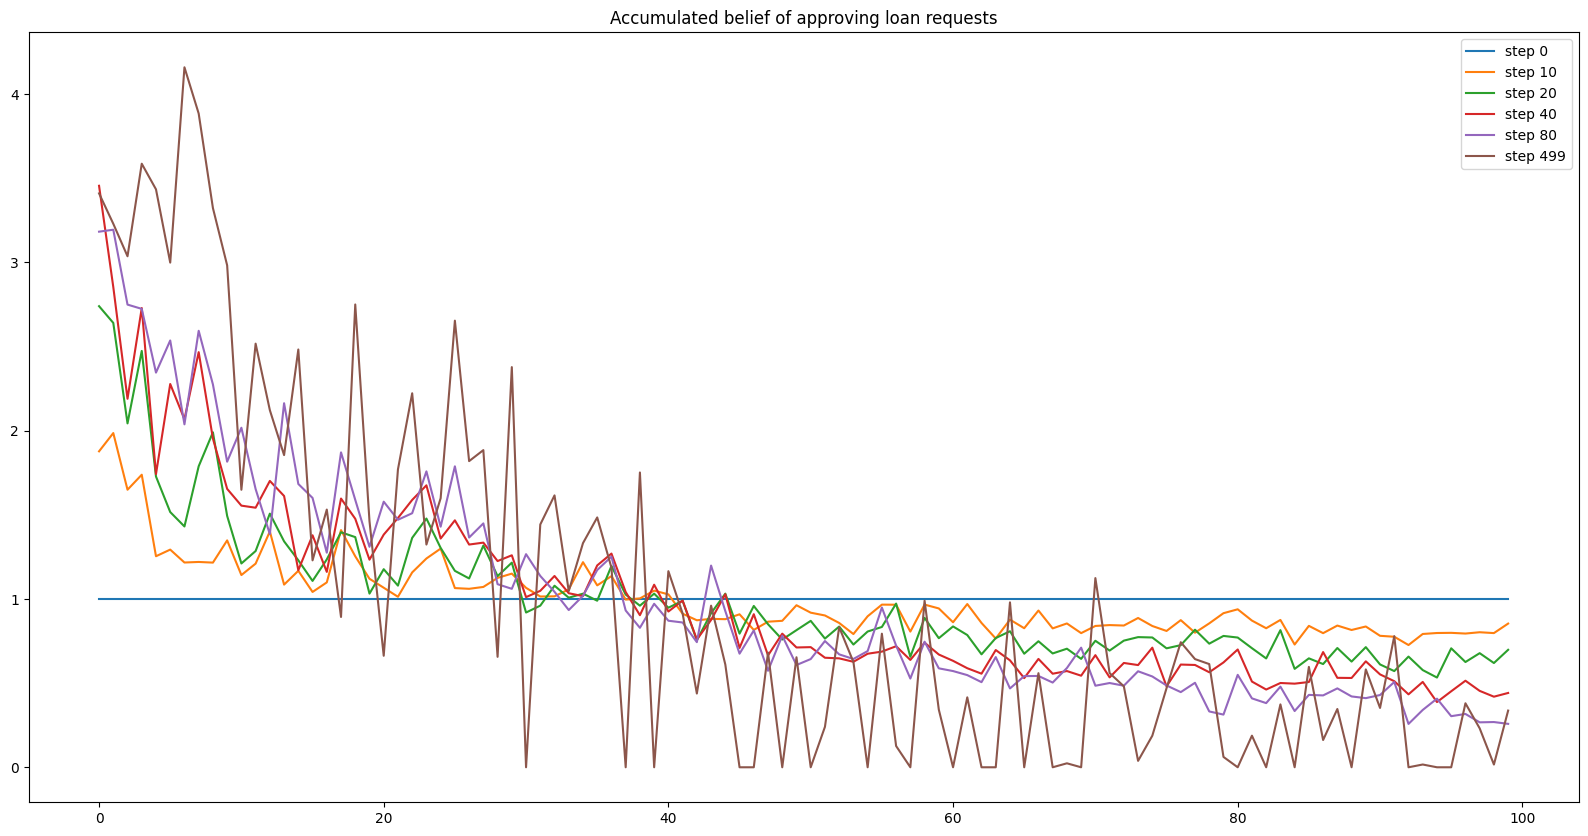

In [5]:
model_data = model_data_collection[0]
plt.figure(figsize=(20,10))
plt.title("Accumulated belief of approving loan requests")
for i in [0,10,20,40,80,499]:
    plt.plot(range(100),model_data["Trust Matrix"][i].sum(axis = 0), label = "step " + str(i))
plt.legend()

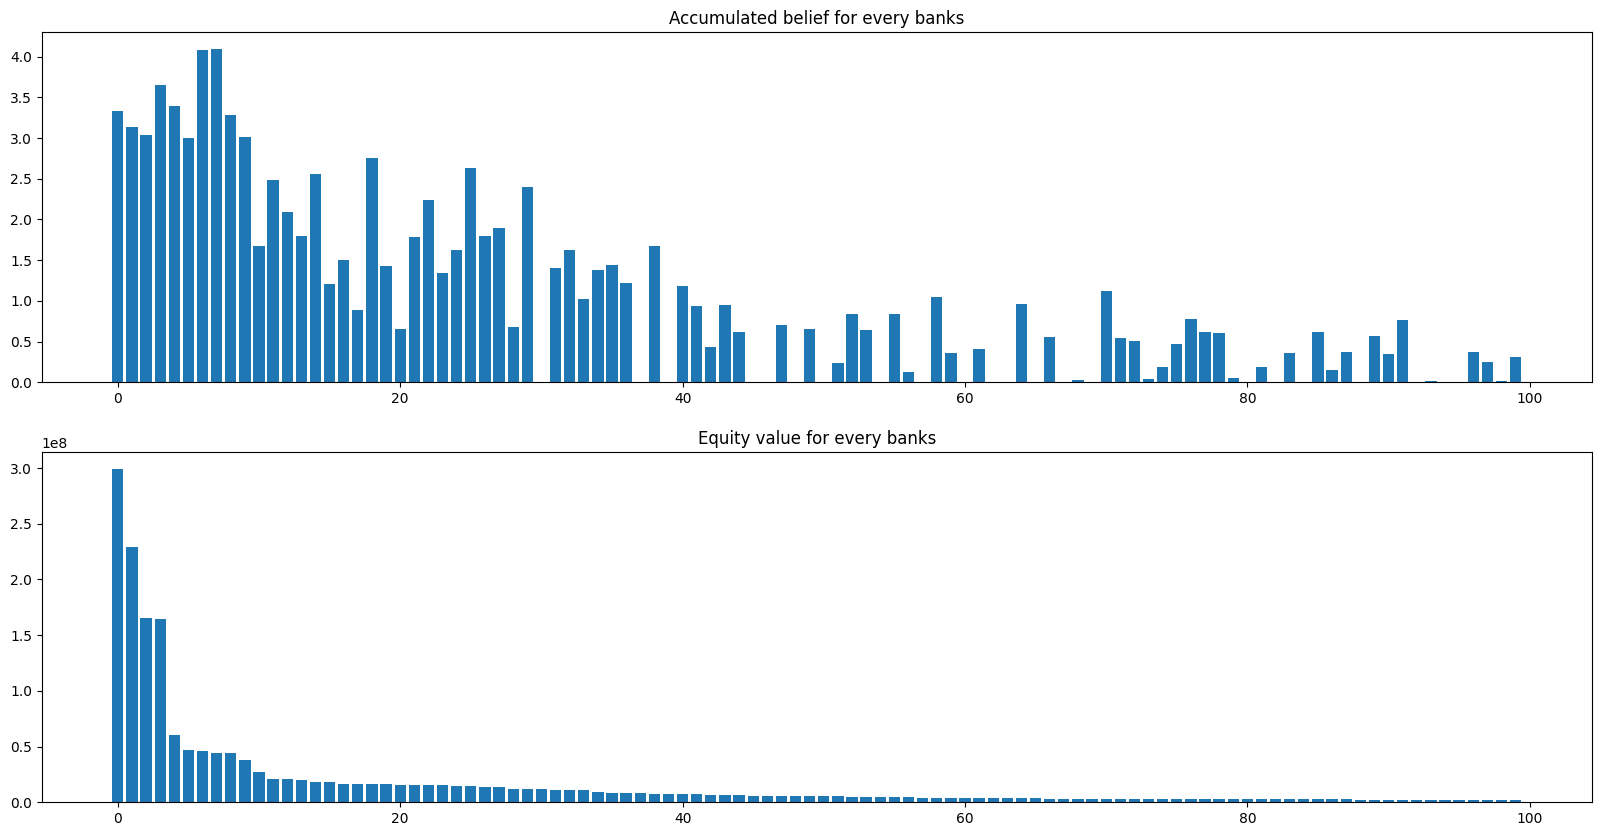

In [6]:
# bar chart of portfolio value
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 10)
ax1.bar(range(model.N), model_data["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated belief for every banks")
ax2.bar(range(model.N), agent_data.xs(0, level="Step")["Equity"])
ax2.set_title("Equity value for every banks")
plt.show()

In [7]:
model.banks.head(10)

0    JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
1        BANK OF AMERICA, NATIONAL ASSOCIATION
2       WELLS FARGO BANK, NATIONAL ASSOCIATION
3                               CITIBANK, N.A.
4                                  TRUIST BANK
5               PNC BANK, NATIONAL ASSOCIATION
6               U.S. BANK NATIONAL ASSOCIATION
7                                TD BANK, N.A.
8                       GOLDMAN SACHS BANK USA
9            CAPITAL ONE, NATIONAL ASSOCIATION
Name: bank, dtype: object

In [9]:
import seaborn as sns
leverages = 0
for agent_data in agent_data_collection:
    leverages += agent_data.xs(300, level="Step")["Leverage"].values
leverages/len(agent_data_collection)

array([ 1.19996394,  1.29992862,  1.59976513,  1.59984237,  4.09683278,
        3.89731372,  3.99710619,  3.09865677,  3.69784216,  4.6961778 ,
        4.5971152 ,  5.49541782,  3.89724918,  5.29505129,  5.49587823,
        3.79807092,  4.6970062 ,  6.69220866,  4.89690531,  5.49585307,
        4.99513589,  4.29750458,  3.79708461,  5.99410685,  4.19775631,
        6.39435126,  5.59520562,  6.19425253,  6.89291176,  5.8946971 ,
        6.09492901,  5.19580941,  6.89291436,  5.4952217 ,  5.79427931,
        6.79252838,  7.09172193,  5.29538254,  6.29438721,  6.29172312,
        6.59335353,  6.69332769,  6.29272486,  6.49357311,  5.39585479,
        8.19006168,  6.09425534,  6.99209137,  6.49343307,  7.19265758,
        6.39400867, 10.58311008,  7.09284303,  7.39174492,  8.58917861,
        8.68796199,  7.78975665,  9.38642647,  8.98735847,  6.7934997 ,
        8.689263  ,  8.98838558,  7.69132145,  8.6886021 ,  8.8870582 ,
        6.89137761,  9.08802718,  7.39193573,  8.38898613,  5.89